# Imports

In [6]:
import os
import re
import sys
import string
import pytreebank
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import umap
import umap.plot

from stemming.porter2 import stem
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import TruncatedSVD

plt.style.use('ggplot')

# Load Data

In [7]:
DATA_PATH = os.path.abspath('stanfordSentimentTreebank/')

phrases = pd.read_csv(DATA_PATH + '/dictionary.txt', delimiter = "|", names=['Phrase', 'Phrase ID1'])
labels = pd.read_csv(DATA_PATH + '/sentiment_labels.txt', delimiter = '|')
labels.columns = ['Phrase ID2', 'Sentiment Value']

sentences = pd.read_csv(DATA_PATH + '/datasetSentences.txt', delimiter = "\t")
sentences_split = pd.read_csv(DATA_PATH + '/datasetSplit.txt', delimiter=',')

In [8]:
phrase_df = phrases.set_index('Phrase ID1').join(labels.set_index('Phrase ID2'), how='inner')\
    .rename_axis(index='Phrase ID').reset_index()

phrase_df.head()

,Phrase ID,Phrase,Sentiment Value
0,0,!,0.50000
1,22935,! ',0.52778
2,18235,! '',0.50000
3,179257,! Alas,0.44444
4,22936,! Brilliant,0.86111


In [9]:
def label_sentiment(row):
  if row['Sentiment Value'] > 0 and row['Sentiment Value'] <= 0.2:
    return 1 # Very negative
  if row['Sentiment Value'] > 0.2 and row['Sentiment Value'] <= 0.4:
    return 2 # negative
  if row['Sentiment Value'] > 0.4 and row['Sentiment Value'] <= 0.6:
    return 3 # Neutral
  if row['Sentiment Value'] > 0.6 and row['Sentiment Value'] <= 0.8:
    return 4 # positive
  if row['Sentiment Value'] > 0.8 and row['Sentiment Value'] <= 1:
    return 5 # Very positive

phrase_df['Sentiment'] = phrase_df.apply(lambda row: label_sentiment(row), axis=1)
phrase_df = phrase_df.dropna()
phrase_df.head()

,Phrase ID,Phrase,Sentiment Value,Sentiment
0,0,!,0.50000,3.0
1,22935,! ',0.52778,3.0
2,18235,! '',0.50000,3.0
3,179257,! Alas,0.44444,3.0
4,22936,! Brilliant,0.86111,5.0


In [10]:
out_path = os.path.join(sys.path[0], 'sst_{}.txt')
dataset = pytreebank.load_sst('./raw_data')

for category in ['train', 'test', 'dev']:
    with open(out_path.format(category), 'w') as outfile:
        for item in dataset[category]:
            outfile.write("__label__{}\t{}\n".format(
                item.to_labeled_lines()[0][0] + 1,
                item.to_labeled_lines()[0][1]
            ))

In [11]:
def read_data(dataset):
    df = pd.read_csv('sst_'+dataset+'.txt', sep='\t', header=None, names=['Label', 'Sentence'])
    df['Label'] = df['Label'].str.replace('__label__', '')
    df['Label'] = df['Label'].astype(int).astype('category')
    return df


train_sent_df = read_data('train')
test_sent_df = read_data('test')
dev_sent_df = read_data('dev')

# Preprocessing 

In [12]:
def preprocess(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]", " ", text)
    token = nltk.word_tokenize(text)
    text = [nltk.stem.SnowballStemmer('english').stem(w) for w in token]
    text = [word.strip() for word in text]
    return " ".join(text)

phrase_df['Phrase clean'] = phrase_df['Phrase'].apply(preprocess)
train_sent_df['Sentence clean'] = train_sent_df['Sentence'].apply(preprocess)
test_sent_df['Sentence clean'] = test_sent_df['Sentence'].apply(preprocess)
dev_sent_df['Sentence clean'] = dev_sent_df['Sentence'].apply(preprocess)

In [13]:
phrase_df.head()

,Phrase ID,Phrase,Sentiment Value,Sentiment,Phrase clean
0,0,!,0.50000,3.0,
1,22935,! ',0.52778,3.0,
2,18235,! '',0.50000,3.0,
3,179257,! Alas,0.44444,3.0,ala
4,22936,! Brilliant,0.86111,5.0,brilliant


In [14]:
filter = phrase_df['Phrase clean'] != ""
phrase_df = phrase_df[filter]

In [15]:
train_phrases, train_labels = phrase_df['Phrase clean'], phrase_df['Sentiment']

# Exploratory Data Analysis

- Classes are imbalanced.
- Majority of phrases are labelled as "neutral".
- Positvies and negatives are fairly balanced.

Text(0.5, 1.0, 'Sentiment class balance')

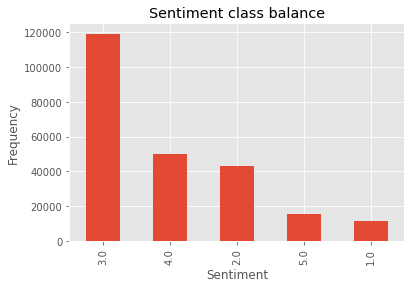

In [16]:
ax = phrase_df['Sentiment'].value_counts().plot(kind='bar')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Frequency')
ax.set_title('Sentiment class balance')

## Dimensionality reduction

- No clear separation between phrases
- Will be difficult to categorize
- Text data is noisy. Perhaps reducing the number of labels -> Negative, Neutral, Positive?

### Truncated SVD

In [17]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True)
X_tfidf = vectorizer.fit_transform(train_phrases)

In [18]:
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_tfidf)

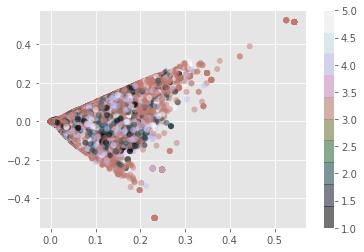

In [19]:
plt.scatter(X_svd[:, 0], X_svd[:, 1], 
            c=train_labels, 
            edgecolor='none', 
            alpha=0.5, 
            cmap=plt.cm.get_cmap('cubehelix', 10))
plt.colorbar()

In [ ]:
train_phrases.head()

# Supervised prediction

## Dummy classifier

In [ ]:
def dummy_pipeline(train, labels, dummy_strategy):
    clf = DummyClassifier(strategy=dummy_strategy)
    pipeline = Pipeline([
        ('vect', TfidfVectorizer(ngram_range=(1,3), sublinear_tf = True)),
        ('clf', LogisticRegression(solver='liblinear', multi_class='auto'))
    ])
    pipeline.fit(train, labels)
    return pipeline

In [ ]:
dummy_pipe_mf = dummy_pipeline(train_phrases, train_labels, 'most_frequent')
dev_sent_df['Dummy pred - mf'] = dummy_pipe_mf.predict(dev_sent_df['Sentence clean']).astype(int)

In [ ]:
dummy_pipe_strat = dummy_pipeline(train_phrases, train_labels, 'stratified')
dev_sent_df['Dummy pred - strat'] = dummy_pipe_strat.predict(dev_sent_df['Sentence clean']).astype(int)

In [ ]:
dev_sent_df.head()

In [ ]:
print("Classification accuracy on the validation set: ")
print(f"'Most frequent' dummy classifier: {accuracy_score(dev_sent_df['Label'], dev_sent_df['Dummy pred - mf']):.3f}")
print(f"'Stratified' dummy classifier: {accuracy_score(dev_sent_df['Label'], dev_sent_df['Dummy pred - strat']):.3f}")